In [1]:
import os
import glob
import torchmetrics.wrappers
from torchmetrics import MetricTracker
from tqdm.auto import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from classes.NIH_dataset_class import NIH_dataset
from classes.Metrics_class import metrics_collection as metrics, metrics_plot

# Importing the hyperparameters
from hyperparams import *

# Load data

In [2]:
# Getting the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Select images paths
DATA_DIR = os.path.join(os.getcwd(), 'dataset')
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))

# Load the data frame to run inference
test_df = pd.read_pickle("test_df.pkl")

# Load the model
model = torch.load('ResNet epochs=100 lr=0.0005 bsize=64.pth')
model.to(device)

# Transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

C:\Users\suvan\AppData\Local\Temp\ipykernel_44972\4003019881.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('ResNet epochs=100 lr=0.0005 bsize=64.pt

In [3]:
test_dataset = NIH_dataset(test_df, image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

D:\College\Fall2024\4ZP6A-capstone\backend\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Batches:   0%|          | 0/7 [00:00<?, ?it/s]

D:\College\Fall2024\4ZP6A-capstone\backend\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


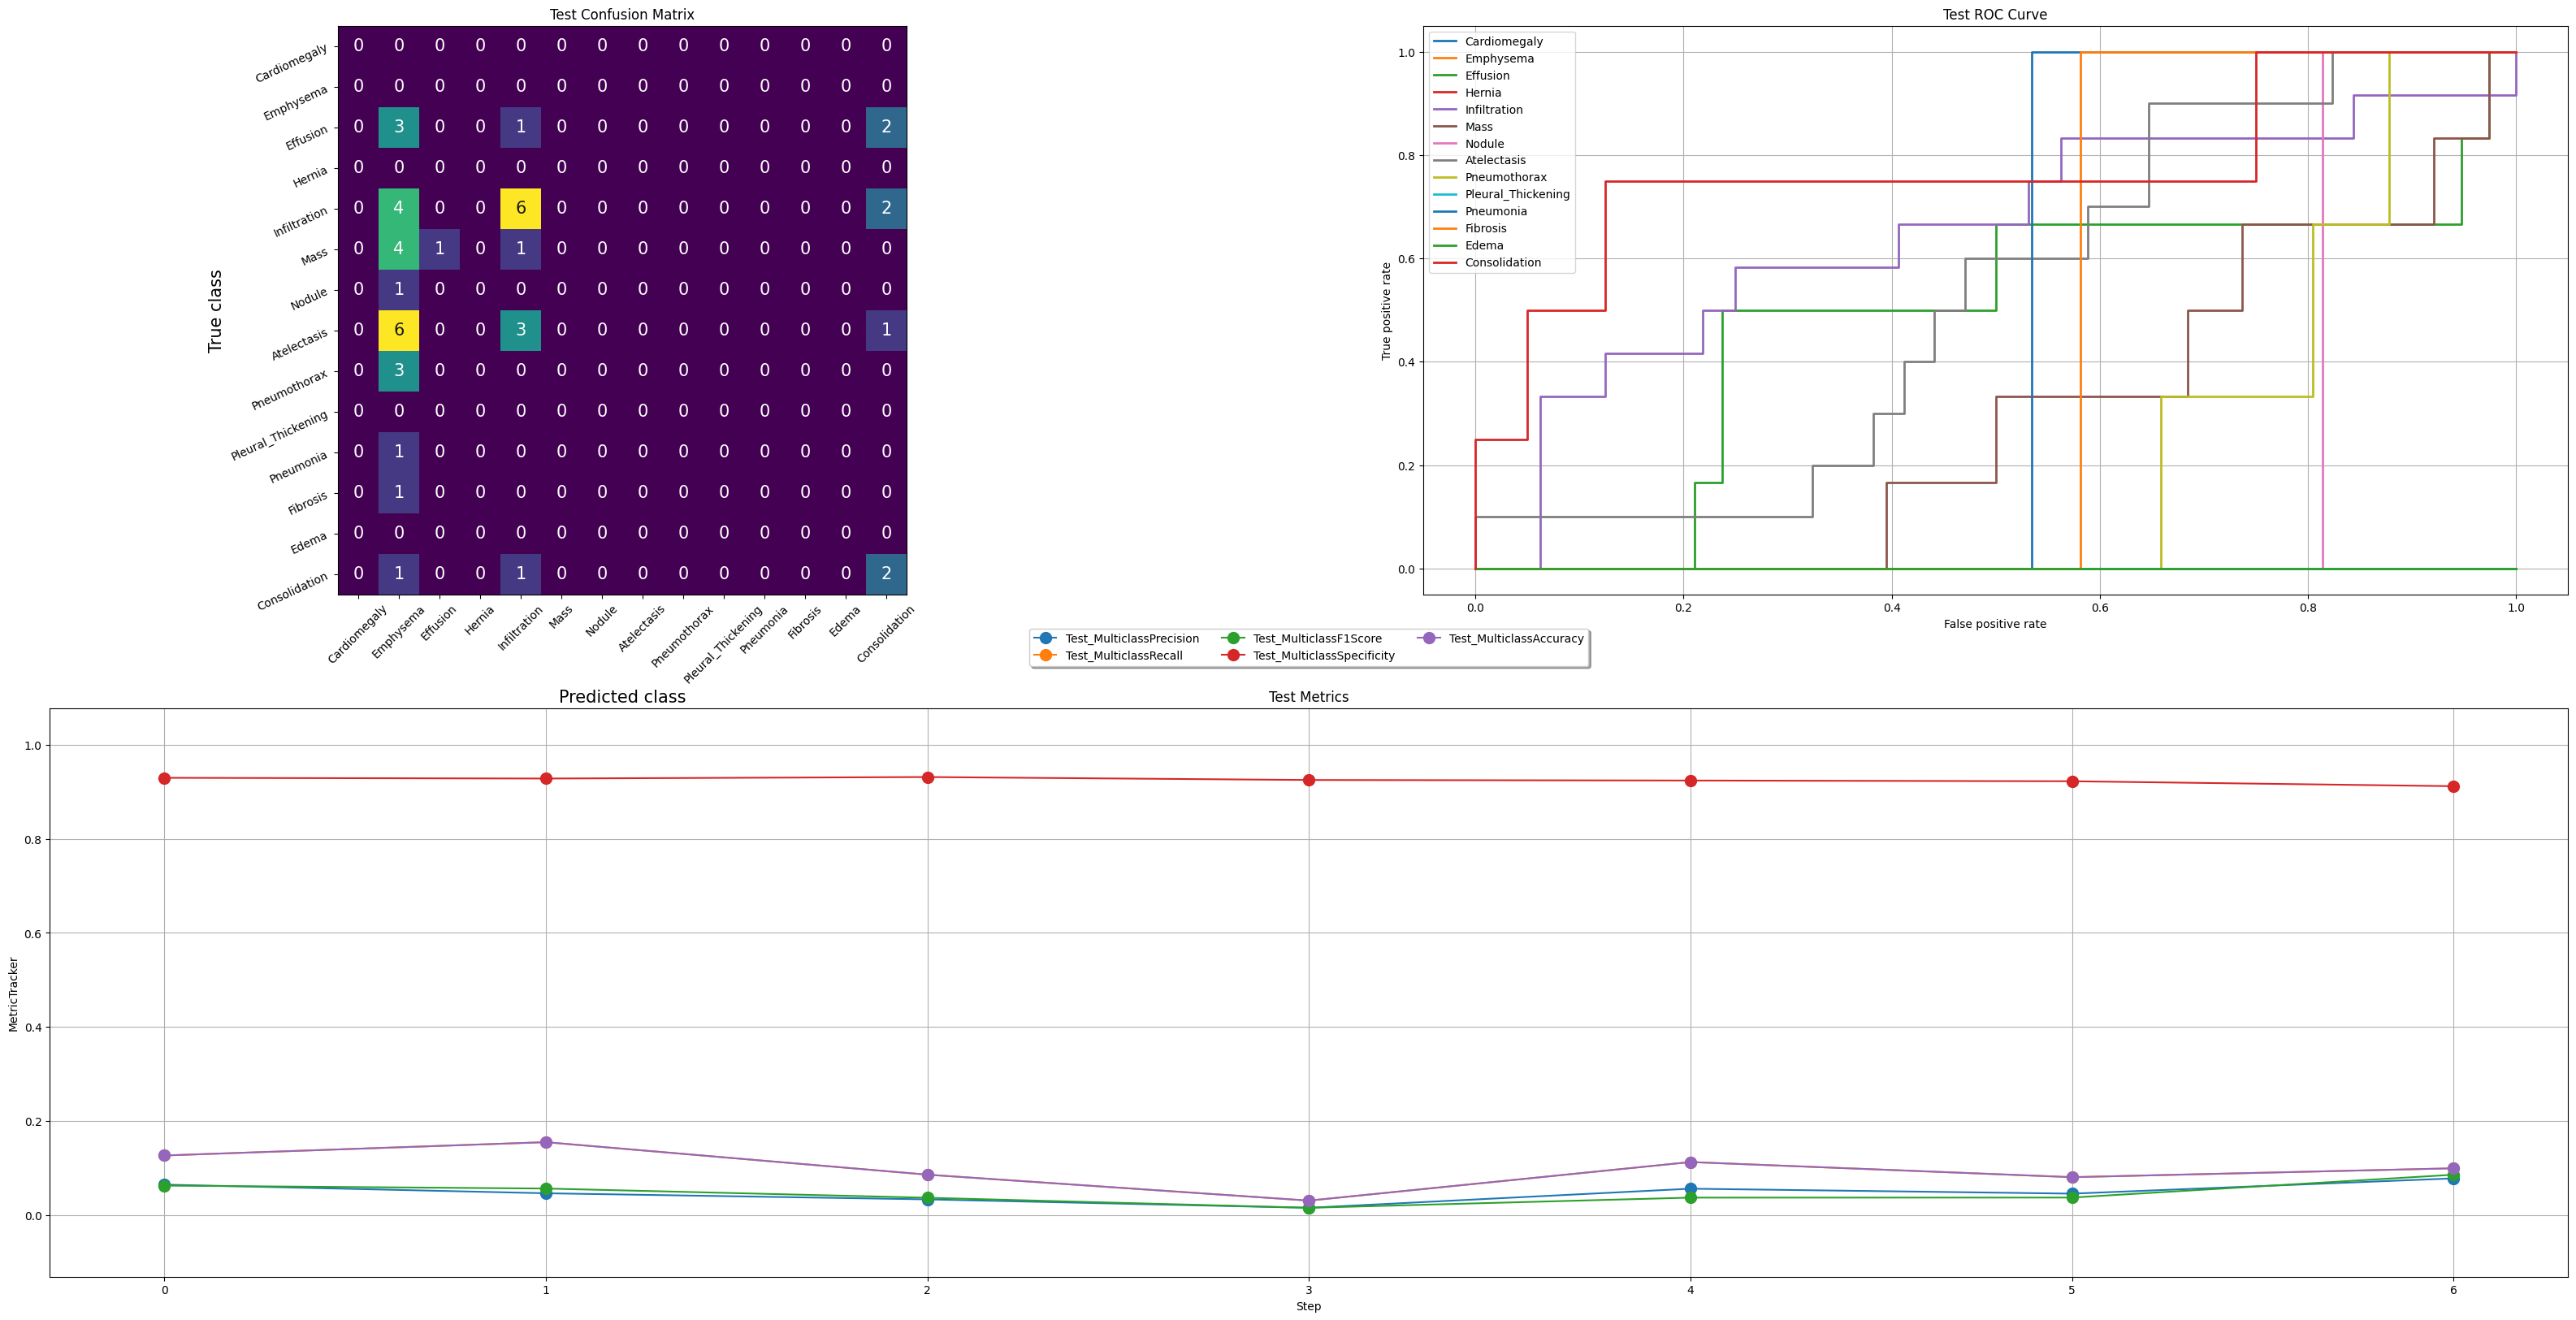

In [4]:
# noinspection PyShadowingNames
def test(model: nn.Module, test_dataloader: DataLoader, criterion: nn.Module) -> tuple[torchmetrics.MetricCollection, MetricTracker]:
    """
    This function tests the model on the test dataset
    :param model: model to test
    :param test_dataloader: dataloader for the test dataset
    :param criterion: criterion to use for the loss
    :return:
    """
    # Defining the metrics
    test_metrics = metrics.clone(prefix="Test_").to(device)
    # Define the torchmetrics tracker
    test_tracker = torchmetrics.wrappers.MetricTracker(test_metrics)

    # Loop through the data. Could add code to add the loss plot
    # ---------------- #
    #   Testing loop   #
    # ---------------- #
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Test Batches"):
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = torch.tensor([disease_to_number[label] for label in labels]).to(device)

            # Forward pass
            outputs = model(inputs)

            # Update Metrics for this batch
            test_tracker.increment()
            test_tracker.update(outputs, labels)

    return test_metrics, test_tracker

# Test the model
test_metrics, test_tracker = test(model=model, test_dataloader=test_loader, criterion=criterion)
# Plot the metrics
metrics_plot(test_tracker, save=True, title1="Test")